#### Código realizado por Alba Márquez Rodríguez

# Práctica 2: Clasificación multi-instancia

## **Objetivo**: El objetivo de esta práctica es introducir los conceptos de clasificación multi-instancia

La práctica se ha realizado siguiendo la opción siguiente:

**OPCIÓN 2: Comparación de métodos**

Seleccione al menos dos algoritmos de los disponibles en la bibliotecas indicadas. Seleccione al menos tres problemas
semi-supervisados de los repositorios indicados.
Realice las siguientes tareas:
1. Aplique los algoritmos seleccionados a los datasets
2. Compare los resultados y explique qué conclusiones se podrían obtener

### Librerías

En las diapositivas del tema se han facilitado 3 librerías para realizar la práctica con python:
- [MISVM](https://github.com/garydoranjr/misvm)
- [MIL: multiple instance learning library for Python](https://github.com/rosasalberto/mil)
- [MILpy: Multiple-Instance Learning Python Toolbox](https://github.com/jmarrietar/MILpy)

Tras leer la documentación de las 3 librerías se optó primero por usar la segunda opción [MIL: multiple instance learning library for Python](https://github.com/rosasalberto/mil). La primera opción parece no tener el repositorio lo suficientemente bien documentado como para facilitar su uso, además, en el README.md viene indicado que aún está en desarrollo, sin embargo, no tiene aportaciones desde hace 8 años. La tercera opción es la más agregada a favoritos en github, sin embargo según la documentación sólo tiene implementados algoritmos y la mayoría basados en SVM. Por comodidad entonces, se ha decidió hacer uso del segundo repositorio, que ya tiene incluídas funciones de importar conjuntos de datos, de algoritmos y de predicción. Sin embargo daba problemas con las versiones de las librerías y dependencias en concreto numpy y tensorflow. Por eso finalmennte se ha optado por la 3ª opción. Sin embargo, sigue habiendo problemas de compatibilidad de librerías. Como solución se ha hecho un clone del repositorio y se ha adaptado a las versiones actuales de las librerías y a los problemas que se necesitaban, siendo una versión diferente de esta librería.

In [2]:
# Importar las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import random as rand

from MILpy.functions.mil_cross_val import mil_cross_val

#Import Algorithms 
from MILpy.Algorithms.BOW import BOW # Bag Space Methods
from MILpy.Algorithms.simpleMIL import simpleMIL  # Instance Space Methods???
from MILpy.Algorithms.MILBoost import MILBoost # Instance Space Methods
# from MILpy.Algorithms.maxDD import maxDD
# from MILpy.Algorithms.CKNN import CKNN
# from MILpy.Algorithms.EMDD import EMDD  # Instance Space Methods

from MILpy.Algorithms.MILES import MILES # Bag Space Methods

In [3]:
# Establecer semilla para reproducibilidad
SEED = 751
np.random.seed(SEED)

rng = np.random.RandomState(SEED)

### Preparación de datos

Se van a utilizar datasets de la página web proporcionada en las diapositivas del tema: [Multiple Instance Learning](http://www.multipleinstancelearning.com/datasets/). Se ha decidido esta opción ya que todos los conjuntos de datos se encuentran en formato CSV, lo que hace que sean más fáciles de importar en python para su posterior procesamiento. En concreto se han elegido los conjuntos de datos:
- *CorelAfrican*
- *Elephant*
- *Fox*

Que además, ya vienen incluídos en la librería seleccionada.

In [4]:
# Import the MILpy modules
from MILpy.data.load_data import load_data

In [5]:
# Corel African
bags_CorelAfrican,labels_CorelAfrican,_ = load_data('corel_african_original')

# Dataset Elephants
bags_Elephant,labels_Elephant,_ = load_data('elephant_original')

# Dataset Fox
bags_Fox,labels_Fox,_ = load_data('fox_original')

### Visualización datasets

A continuación se visualizarán los datasets (la distribución que tienen)

#### Funciones auxiliares

In [6]:
# Función para obtener información sobre los datos
def get_data_info(bags, labels):
    bags_per_label = {}
    bags_count = len(bags)
    labels_count = len(set(labels.flatten()))

    for i in range(bags_count):
        bag_labels = set(labels[i])
        for label in bag_labels:
            if label not in bags_per_label:
                bags_per_label[label] = 1
            else:
                bags_per_label[label] += 1

    return bags_per_label, bags_count, labels_count

# Función para visualizar información en un gráfico de barras
def plot_bar_chart(bags_info, dataset_name):
    labels = list(bags_info.keys())
    values = list(bags_info.values())

    plt.figure(figsize=(10, 5))
    plt.bar(labels, values, color='skyblue')
    plt.xlabel('Label')
    plt.ylabel('Número de Bags')
    plt.title(f'Distribución de Bags por Label en {dataset_name}')
    plt.show()

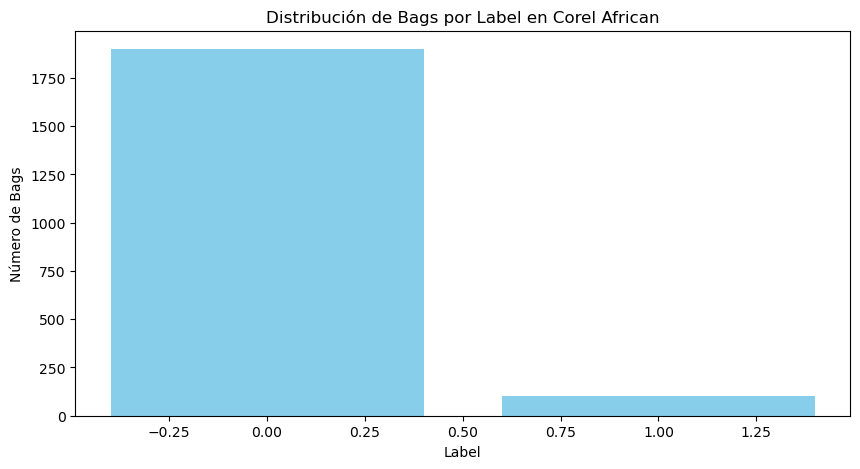

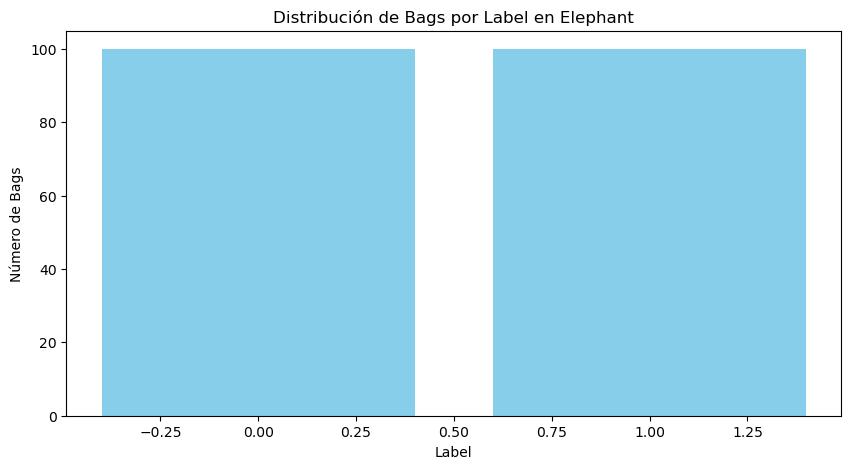

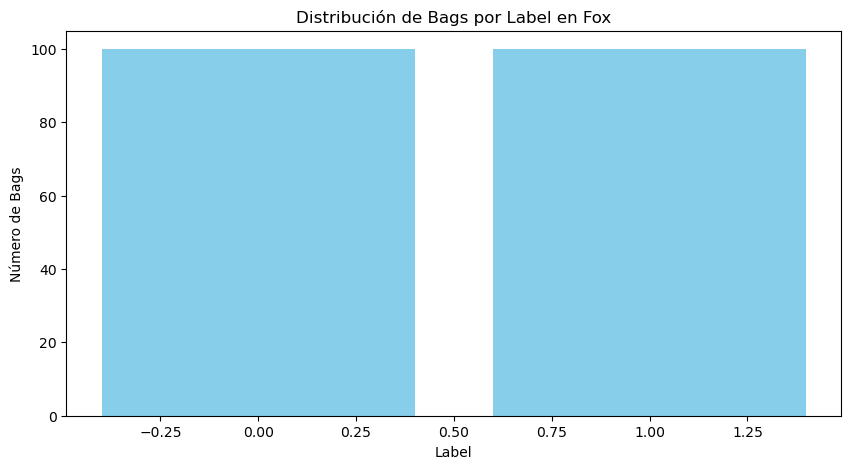

In [7]:
# Obtener información para cada conjunto de datos
bags_info_CorelAfrican, bags_count_CorelAfrican, labels_count_CorelAfrican = get_data_info(bags_CorelAfrican, labels_CorelAfrican)
bags_info_Elephant, bags_count_Elephant, labels_count_Elephant = get_data_info(bags_Elephant, labels_Elephant)
bags_info_Fox, bags_count_Fox, labels_count_Fox = get_data_info(bags_Fox, labels_Fox)

# Visualizar información para cada conjunto de datos
plot_bar_chart(bags_info_CorelAfrican, 'Corel African')
plot_bar_chart(bags_info_Elephant, 'Elephant')
plot_bar_chart(bags_info_Fox, 'Fox')


In [8]:
# Mostrar información general
print(f'Total de Bags en Corel African: {bags_count_CorelAfrican}, Labels diferentes: {labels_count_CorelAfrican}')
print(f'Total de Bags en Elephant: {bags_count_Elephant}, Labels diferentes: {labels_count_Elephant}')
print(f'Total de Bags en Fox: {bags_count_Fox}, Labels diferentes: {labels_count_Fox}')

Total de Bags en Corel African: 2000, Labels diferentes: 2
Total de Bags en Elephant: 200, Labels diferentes: 2
Total de Bags en Fox: 200, Labels diferentes: 2


### División del dataset

Se va a realizar un shuffle de los datos, para buscar mayor variabilidad.

Y en vez de utilizar una separación en train y test se realizará por validación cruzada.

In [9]:
# Corel African
bags_CorelAfrican, labels_CorelAfrican = shuffle(bags_CorelAfrican, labels_CorelAfrican, random_state=SEED)
# train_bags_CorelAfrican, test_bags_CorelAfrican, train_labels_CorelAfrican, test_labels_CorelAfrican = train_test_split(bags_CorelAfrican, labels_CorelAfrican, test_size=0.2, random_state=SEED)

# Elephant
bags_Elephant, labels_Elephant = shuffle(bags_Elephant, labels_Elephant, random_state=SEED)
# train_bags_Elephant, test_bags_Elephant, train_labels_Elephant, test_labels_Elephant = train_test_split(bags_Elephant, labels_Elephant, test_size=0.2, random_state=SEED)

# Fox
bags_Fox, labels_Fox = shuffle(bags_Fox, labels_Fox, random_state=SEED)
# train_bags_Fox, test_bags_Fox, train_labels_Fox, test_labels_Fox = train_test_split(bags_Fox, labels_Fox, test_size=0.2, random_state=SEED)


In [10]:
#Number of Folds 
folds=5

## Algoritmos

A continuación se explican y aplican los algoritmos multinstancia que se van a utilizar en esta práctica.

### Bag Of Words

El algoritmo Bag of Words (BoW) representa documentos de texto como vectores de características, donde cada componente del vector corresponde a la frecuencia de una palabra en el documento. El proceso implica tokenizar el texto para dividirlo en palabras, construir un vocabulario único y luego contar la frecuencia de cada palabra en cada documento. Este enfoque simplificado ignora el orden y la estructura gramatical, centrándose únicamente en la presencia y frecuencia de palabras. BoW es comúnmente utilizado en tareas de procesamiento de lenguaje natural como clasificación de texto y análisis de sentimientos.

In [14]:
bow_classifier = BOW() 

# Corel African
accuracie_CoralAfrican, results_accuracie_CoralAfrican, auc_CoralAfrican,results_auc_CoralAfrican  = mil_cross_val(bags=bags_CorelAfrican,labels=labels_CorelAfrican, model=bow_classifier, folds=folds, parameters=parameters_bow)

# Elephant
accuracie_Elephant, results_accuracie_Elephant, auc_Elephant,results_auc_Elephant  = mil_cross_val(bags=bags_Elephant,labels=labels_Elephant, model=bow_classifier, folds=folds, parameters=parameters_bow)

# Fox
accuracie_Fox, results_accuracie_Fox, auc_Fox,results_auc_Fox  = mil_cross_val(bags=bags_Fox,labels=labels_Fox, model=bow_classifier, folds=folds, parameters=parameters_bow)

print("\n\n\n\n")
print("Corel African - BOW")
print("Accuracy: ",accuracie_CoralAfrican)
print("AUC: ",auc_CoralAfrican)

print("\n")
print("Elephant - BOW")
print("Accuracy: ",accuracie_Elephant)
print("AUC: ",auc_Elephant)

print("\n")
print("Fox - BOW")
print("Accuracy: ",accuracie_Fox)
print("AUC: ",auc_Fox)

Fold# 0...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 1...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 2...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 3...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 4...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 0...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 1...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 2...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 3...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 4...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 0...Fold# 1...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 2...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 3...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 4...




Corel African - BOW
Accuracy:  95.0
AUC:  50.0


Elephant - BOW
Accuracy:  70.0
AUC:  70.0


Fox - BOW
Accuracy:  51.0
AUC:  51.0


c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### simpleMIL



In [15]:
SMILa = simpleMIL()
parameters_smil = {'type': 'average'}

# Corel African
accuracie_CoralAfrican, results_accuracie_CoralAfrican, auc_CoralAfrican,results_auc_CoralAfrican  = mil_cross_val(bags=bags_CorelAfrican,labels=labels_CorelAfrican, model=SMILa, folds=folds, parameters=parameters_smil)

# Elephant
accuracie_Elephant, results_accuracie_Elephant, auc_Elephant,results_auc_Elephant  = mil_cross_val(bags=bags_Elephant,labels=labels_Elephant, model=SMILa, folds=folds, parameters=parameters_smil)

# Fox
accuracie_Fox, results_accuracie_Fox, auc_Fox,results_auc_Fox  = mil_cross_val(bags=bags_Fox,labels=labels_Fox, model=SMILa, folds=folds, parameters=parameters_smil)

print("\n\n\n\n")
print("Corel African - simpleMIL")
print("Accuracy: ",accuracie_CoralAfrican)
print("AUC: ",auc_CoralAfrican)

print("\n")
print("Elephant - simpleMIL")
print("Accuracy: ",accuracie_Elephant)
print("AUC: ",auc_Elephant)

print("\n")
print("Fox - simpleMIL")
print("Accuracy: ",accuracie_Fox)
print("AUC: ",auc_Fox)

Fold# 0...Fold# 1...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 2...Fold# 3...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Fold# 4...Fold# 0...Fold# 1...Fold# 2...Fold# 3...Fold# 4...Fold# 0...Fold# 1...

c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d ar

Fold# 2...Fold# 3...Fold# 4...




Corel African - SMILa
Accuracy:  95.0
AUC:  50.0


Elephant - SMILa
Accuracy:  77.0
AUC:  77.0


Fox - SMILa
Accuracy:  63.0
AUC:  63.0


c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\albam\anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### MILBoost

MILBoost es un algoritmo de aprendizaje multiinstancia (MIL) que combina la metodología de boosting con la clasificación de conjuntos. Se centra en mejorar la capacidad de clasificación de instancias positivas dentro de bolsas positivas. En cada iteración, MILBoost ajusta un clasificador débil, asignando pesos a las bolsas según su rendimiento previo. Este enfoque iterativo busca seleccionar instancias más informativas en cada paso, mejorando gradualmente la precisión del modelo en problemas donde la etiqueta de la bolsa está vinculada a la presencia de instancias positivas.

In [17]:
milboost_classifier = MILBoost() 

# Corel African
accuracie_CoralAfrican, results_accuracie_CoralAfrican, auc_CoralAfrican,results_auc_CoralAfrican  = mil_cross_val(bags=bags_CorelAfrican,labels=labels_CorelAfrican, model=milboost_classifier, folds=folds)

# Elephant
accuracie_Elephant, results_accuracie_Elephant, auc_Elephant,results_auc_Elephant  = mil_cross_val(bags=bags_Elephant,labels=labels_Elephant, model=milboost_classifier, folds=folds)

# Fox
accuracie_Fox, results_accuracie_Fox, auc_Fox,results_auc_Fox  = mil_cross_val(bags=bags_Fox,labels=labels_Fox, model=milboost_classifier, folds=folds)

print("\n\n\n\n")
print("Corel African - MILBoost")
print("Accuracy: ",accuracie_CoralAfrican)
print("AUC: ",auc_CoralAfrican)

print("\n")
print("Elephant - MILBoost")
print("Accuracy: ",accuracie_Elephant)
print("AUC: ",auc_Elephant)

print("\n")
print("Fox - MILBoost")
print("Accuracy: ",accuracie_Fox)
print("AUC: ",auc_Fox)

Fold# 0...Fold# 1...Fold# 2...Fold# 3...Fold# 4...Fold# 0...Fold# 1...Fold# 2...Fold# 3...Fold# 4...Fold# 0...Fold# 1...Fold# 2...Fold# 3...Fold# 4...




Corel African - MILBoost
Accuracy:  5.225
AUC:  51.625


Elephant - MILBoost
Accuracy:  50.0
AUC:  87.7


Fox - MILBoost
Accuracy:  50.0
AUC:  56.85


## Análisis

### Bag of Words (BOW)
- **Corel African:** Se logra un accuracy muy alto, del 95%, pero un AUC del 50%, indicando que el modelo podría estar prediciendo correctamente sólo una clase, probablemente la clase mayoritaria. Pues es un conjunto de datos muy desbalanceado

- **Elephant:** Aunque el accuracy es bueno aunque moderado (70%), el AUC del 70% sugiere un rendimiento razonable en la discriminación de clases, mostrando capacidad para distinguir entre instancias tanto positivas como negativas.

- **Fox:** La accuracy y AUC del 51% sugieren un rendimiento limitado, posiblemente debido a la composición del dataset. Este resultado puede indicar desafíos en la discriminación entre clases.

### SimpleMIL
- **Corel African:** Mantiene una accuracy del 95%, pero el AUC del 50% sugiere un rendimiento similar al algoritmo BOW. Indicando los mismos problemas. Probablemente se deba al desbalanceo.

- **Elephant:** Aumenta el accuracy al 77%, mostrando una mejora, pero el AUC del 77% sugiere cierta capacidad para discriminar.

- **Fox:** El accuracy y AUC del 63% muestran un rendimiento aceptable. La igualdad en ambas métricas podría sugerir un mejor rendimiento general en este conjunto de datos.

### MILBoost
- **Corel African:** El accuracy es extremadamente bajo, del 5.225% y el AUC del 51.625% sugieren dificultades para ajustarse al modelo. Este resultado puede deberse a problemas específicos en el proceso de boosting o la naturaleza del conjunto de datos.

- **Elephant:** El accuracy del 50% indica un rendimiento similar al azar, pero el AUC del 87.7% sugiere un rendimiento mejorado en la discriminación de clases.

- **Fox:** El accuracy y AUC del 50% y 56.85%, respectivamente, indican unos resultados muy similares a los que se podrían obtener con un clasificador aleatorio.

## Conclusiones
- BOW muestra una alta accuracy en Corel African, pero su rendimiento puede estar sesgado por la clase mayoritaria. Esta situación muestra la importancia de considerar diferentes métrias para entender el conjunto de datos, el modelo obtenido y posibles soluciones para mejorar el modelo. En este caso se ha tenido en cuenta tanto la accuracy como el AUC.

- SimpleMIL presenta mejoras en Elephant, pero Fox muestra limitaciones. La igualdad entre accuracy y AUC en SimpleMIL puede indicar la influencia de la composición del dataset y la dificultad para discriminar entre instancias. Es importante tamién indicar que estos datasets tienen menos instancias que Corel African.

- MILBoost tiene dificultades en Corel African y Fox, aunque destaca en Elephant. La discrepancia entre accuracy y AUC en MILBoost puede reflejar su sensibilidad a la naturaleza específica de los datos y la capacidad de discriminación de instancias positivas.

- En resumen, la elección del algoritmo depende de la naturaleza única de los datos y los objetivos de clasificación.

Por otro lado, respecto a la implentación de esta práctica, ha supuesto un reto ya que todas las librerías llevan sin tener soporte varios años, tienen librerías más antiguas y con métodos que ya han sido "deprecados". Por eso se ha tenido que utilizar una versión editada de la librería finalmente seleccionada, en este caso, MILpy. Ajustando las funciones a los métodos actualizados de la librería así como la propia sintáxis del código. Lo que se ha traducido en una gran inversión de tiempo para solucionar los problemas y llegar al entendimiento de la librería.

## Otros algoritmos estudiados

### MILES

MILES (Multiple-Instance Learning via Embedded Instance Selection) es un algoritmo de aprendizaje multiinstancia (MIL) diseñado para abordar problemas en los que las instancias positivas y negativas pueden coexistir en la misma bolsa.

MILES utiliza una estrategia de selección de instancias incrustadas para identificar las instancias más relevantes dentro de cada bolsa, diferenciando entre instancias positivas y negativas. Luego, aplica un clasificador basado en estas instancias seleccionadas para realizar la clasificación. Este enfoque permite a MILES manejar de manera efectiva la presencia de instancias de ambas clases en una misma bolsa, lo que lo hace adecuado para problemas en los que las etiquetas de las bolsas no son completamente informativas sobre la presencia de instancias positivas.

Los cambios realizados en la librería se pueden encontrar en la [carpeta de la asignatura del repositorio Github del Máster](https://github.com/GrunCrow/MUICE_UCO_Code/tree/main/1º%20Cuatrimestre/%5BCNC%5D%20-%20Clasificación%20No%20Convencional/Prácticas/Practica2/MILpy)